In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
from scipy.integrate import quad

from ler.gw_source_population import CBCSourceRedshiftDistribution
from ler.gw_source_population import CBCSourceParameterDistribution
from ler.utils import  interpolator_from_pickle

In [2]:
cbc = CBCSourceRedshiftDistribution(
    z_min=0.001,
    z_max=10.0,
    event_type="BBH",
    merger_rate_density="merger_rate_density_bbh_popI_II_oguri2018",
    merger_rate_density_param=dict(R0=23.9 * 1e-9, b2=1.6, b3=2.0, b4=30),
    cosmology=None,
    directory="./interpolator_pickle",
    create_new_interpolator=dict(redshift_distribution=dict(create_new=False, resolution=500), z_to_Dl=dict(create_new=False, resolution=500), differential_comoving_volume=dict(create_new=False, resolution=500))
)
# cbc = CBCSourceRedshiftDistribution(
#     z_min=0.001,
#     z_max=30.0,
#     nsamples_z=500,
#     event_type="BBH",
#     merger_rate_density="merger_rate_density_primordial_ken2022",
#     #merger_rate_density_param=dict(n0=19.2 * 1e-9, aIII=0.66, bIII=0.3, zIII=14.6),
#     cosmology=None,
#     directory="./interpolator_pickle",
#     create_new_interpolator=dict(redshift_distribution=False, z_to_Dl=False, differential_comoving_volume=False)
# )

z_to_luminosity_distance interpolator will be loaded from ./interpolator_pickle/z_to_luminosity_distance/z_to_luminosity_distance_1.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_2.pickle
merger_rate_density_bbh_popI_II_oguri2018 interpolator will be generated at ./interpolator_pickle/merger_rate_density_bbh_popI_II_oguri2018/merger_rate_density_bbh_popI_II_oguri2018_6.pickle


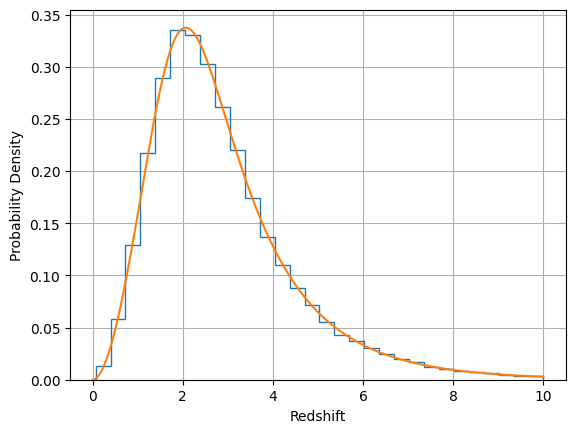

In [3]:
# plot the redshift distribution
z = np.linspace(0.001, 10, 1000)
zs = cbc.sample_source_redshift(50000)
plt.hist(zs, bins=30, density=True, histtype="step")
plt.plot(z, cbc.pdf_z(z, param=None))
#dist = np.random.normal(2,1, 1000)
# plt.hist(dist, bins=30, density=True, histtype="step")
plt.xlabel("Redshift")
plt.ylabel("Probability Density")
plt.grid()
plt.show()

In [2]:
cbc = CBCSourceParameterDistribution(spin_zero=True, spin_precession=False)

z_to_luminosity_distance interpolator will be loaded from ./interpolator_pickle/z_to_luminosity_distance/z_to_luminosity_distance_0.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_2.pickle
merger_rate_density_bbh_popI_II_oguri2018 interpolator will be loaded from ./interpolator_pickle/merger_rate_density_bbh_popI_II_oguri2018/merger_rate_density_bbh_popI_II_oguri2018_5.pickle


In [4]:
%timeit test = cbc.sample_gw_parameters(25000)

9.63 ms ± 25.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
%time test = cbc.sample_gw_parameters(100000)

CPU times: user 41.1 ms, sys: 3.15 ms, total: 44.3 ms
Wall time: 43.3 ms


In [15]:
#ra = cbc.sample_ra(100000)
#dec = cbc.sample_dec(100000)
phase = cbc.sample_phi_12(100000)


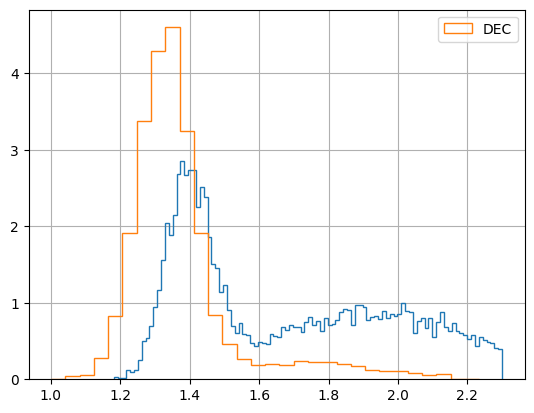

In [9]:
# plot the sky position distribution 1D
plt.hist(m1, bins=100, density=True, histtype="step")
plt.hist(m2, bins=30, density=True, histtype="step", label="DEC")
plt.legend()
plt.grid()
plt.show()

In [6]:
from ler.gw_source_population import inverse_transform_sampler_m1m2
directory = "./interpolator_pickle"

def binary_masses_BNS_bimodal(
    size,
    w=0.643,
    muL=1.352,
    sigmaL=0.08,
    muR=1.88,
    sigmaR=0.3,
    mmin=1.0,
    mmax=2.3,
    resolution=500,
    create_new=False,
    get_attribute=False,
    param=None,

):
    if param:
        w, muL, sigmaL, muR, sigmaR, mmin, mmax = (
            param["w"],
            param["muL"],
            param["sigmaL"],
            param["muR"],
            param["sigmaR"],
            param["mmin"],
            param["mmax"],
        )
   # left and right peak
    pdf_unnormL = lambda m: np.exp(-((m - muL) ** 2) / (2 * sigmaL**2))
    normL = quad(pdf_unnormL, mmin, mmax)[0]  # normalization constant
    pdf_unnormR = lambda m: np.exp(-((m - muR) ** 2) / (2 * sigmaR**2))
    normR = quad(pdf_unnormR, mmin, mmax)[0]  # normalization constant
    # total pdf
    pdf = lambda m: w * pdf_unnormL(m) / normL + (1 - w) * pdf_unnormR(m) / normR 

    # find inverse cdf
    inv_cdf = interpolator_from_pickle(
        param_dict_given= dict(w=0.643, muL=1.352, sigmaL=0.08, muR=1.88, sigmaR=0.3, mmin=1.0, mmax=2.3, resolution=500),
        directory=directory,
        sub_directory="binary_masses_BNS_bimodal",
        name="binary_masses_BNS_bimodal",
        x = np.linspace(mmin, mmax, resolution),
        pdf_func= pdf,
        conditioned_y=None,
        dimension=1,
        category="inv_cdf",
        create_new=create_new,
    )
    
    # sample from inverse cdf
    if get_attribute:
        return njit(lambda size_: inverse_transform_sampler_m1m2(size_, inv_cdf[0], inv_cdf[1]))
    else:
        return inverse_transform_sampler_m1m2(size, inv_cdf[0], inv_cdf[1])



In [7]:
test =  binary_masses_BNS_bimodal(10000, get_attribute=True)

binary_masses_BNS_bimodal interpolator will be loaded from ./interpolator_pickle/binary_masses_BNS_bimodal/binary_masses_BNS_bimodal_0.pickle


In [8]:
m1,m2 = test(10000)

In [25]:
%timeit m1,m2 = lognormal_distribution_2D(10000)

16 ms ± 98 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
np.sum(m1 < m2)

0

In [43]:
@njit
def cos_icdf(p):

    return np.arcsin((p-0.5)*np.pi)

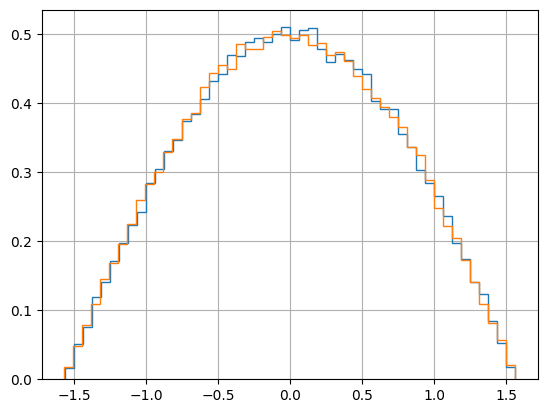

In [44]:
u = np.random.uniform(0,1,100000)
dec_ = cos_icdf(u)
plt.hist(dec_, bins=50, density=True, histtype="step")
plt.hist(dec, bins=50, density=True, histtype="step", label="DEC")
plt.grid()
plt.show()

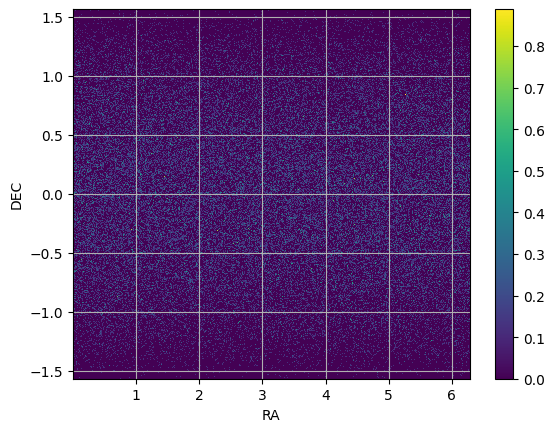

In [23]:
# contour plot of the sky position distribution
plt.hist2d(ra, dec, bins=500, density=True)
plt.xlabel("RA")
plt.ylabel("DEC")
plt.colorbar()
plt.grid()
plt.show()

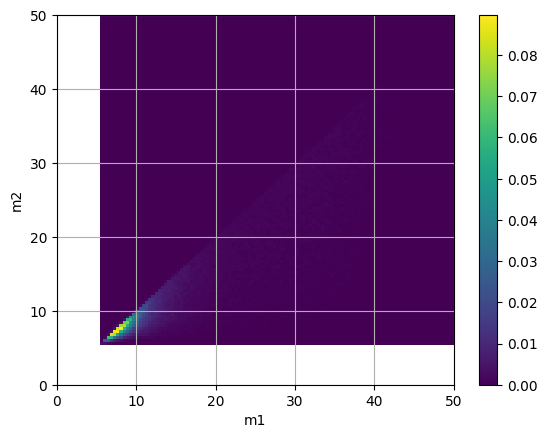

In [28]:
m1, m2 = cbc.sample_source_frame_masses(100000)

# plot the mass distribution
plt.hist2d(m1, m2, bins=200, density=True)
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.xlabel("m1")
plt.ylabel("m2")
plt.colorbar()
plt.grid()
plt.show()

In [9]:
%timeit cbc.sample_geocent_time(100000)

393 µs ± 2.82 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [10]:
%timeit cbc.geocent_time_uniform(100000)

392 µs ± 5.68 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [3]:
param_names = list(cbc.gw_param_samplers.keys())
samplers_params = list(cbc.gw_param_samplers_params.values())
del param_names[0]  # remove merger_rate_density
del samplers_params[0]  # remove merger_rate_density
# make sure the order is correct
sampler_names = list(cbc.sampler_names.keys())

In [14]:
param_names

['source_frame_masses',
 'spin',
 'zs',
 'geocent_time',
 'sky_position',
 'phase',
 'psi',
 'theta_jn']

In [10]:
idx = 6
name = param_names[idx]
sampler = sampler_names[idx]
param_ = samplers_params[idx]
size = 10
getattr(cbc, sampler)(size=size, param=param_)

array([1.36675118, 0.15667616, 1.72830251, 2.85891013, 0.53555306,
       0.87228794, 1.00539111, 1.73959809, 1.64879054, 0.59769173])

In [4]:
cbc.gw_param_samplers["spin"]

'binary_spin_aligned'

In [5]:
params = cbc.sample_gw_parameters(10000)

In [6]:
params.keys()

dict_keys(['zs', 'geocent_time', 'phase', 'psi', 'theta_jn', 'luminosity_distance', 'mass_1_source', 'mass_2_source', 'mass_1', 'mass_2', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'ra', 'dec'])

In [7]:
params["tilt_1"]

array([0., 0., 0., ..., 0., 0., 0.])

## Test for custom njit cubicspline

In [2]:
z = np.linspace(0.001, 10., 500)
spline1 = interpolator_from_pickle(
    param_dict_given= dict(z_min=0.001, z_max=10., cosmology=cosmo),
    directory="./interpolator_pickle",
    sub_directory="z_to_Dl",
    name="z_to_Dl",
    x = z,
    pdf_func= lambda z_: cosmo.luminosity_distance(z_).value, 
    conditioned_y=None, 
    dimension=1,
    category="function",
    create_new=True,
)

z_to_Dl interpolator will be generated at ./interpolator_pickle/z_to_Dl/z_to_Dl_2.pickle


In [3]:
spline1[0]

array([[-1.16659378e+03, -1.16659378e+03, -1.15839852e+03, ...,
        -2.49678737e+00, -2.48214949e+00, -2.48214950e+00],
       [ 3.31541090e+03,  3.24528201e+03,  3.17515313e+03, ...,
         5.42634538e+01,  5.41133614e+01,  5.39641489e+01],
       [ 4.28938629e+03,  4.42084995e+03,  4.54950312e+03, ...,
         1.17892648e+04,  1.17914364e+04,  1.17936021e+04],
       [ 4.28606736e+00,  9.15589490e+01,  1.81437951e+02, ...,
         1.03133848e+05,  1.03370104e+05,  1.03606403e+05]])

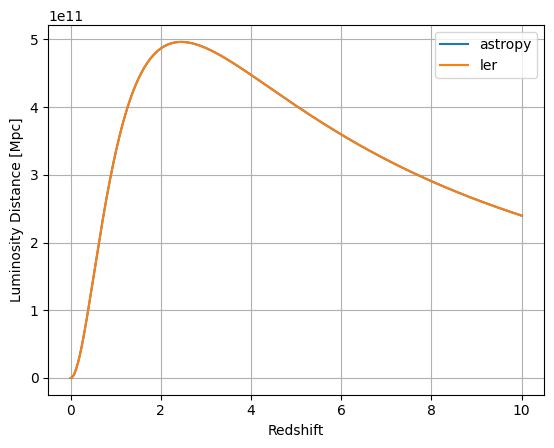

In [8]:
z = np.linspace(0.001, 10, 1000)
plt.plot(z, cbc.cosmo.differential_comoving_volume(z).value* 4 * np.pi , label="astropy")
plt.plot(z, cbc.differential_comoving_volume(z), label="ler")
plt.xlabel("Redshift")
plt.ylabel("Luminosity Distance [Mpc]")
plt.legend()
plt.grid()
plt.show()


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad, cumtrapz

In [4]:
# gaussian distribution function
def gaussian(x, amp=2, mu=5, sig=1):
    return amp*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

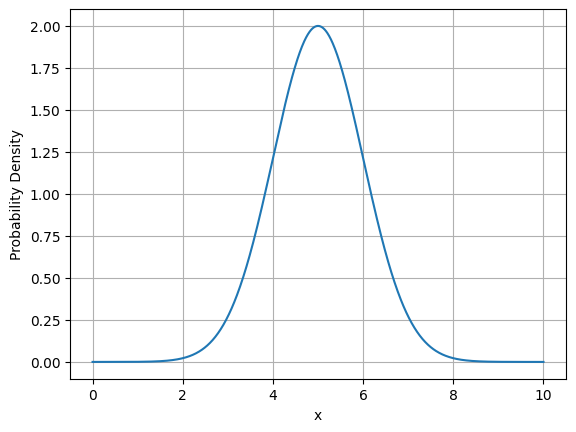

In [5]:
# plot gaussian distribution
x = np.linspace(0, 10, 1000)
plt.plot(x, gaussian(x))
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.grid()

In [12]:
x = np.linspace(0, 10, 500)
y = gaussian(x)
pdf_unorm = interp1d(x, y, kind="cubic", fill_value="extrapolate")
min_, max_ = min(x), max(x)
norm = quad(pdf_unorm, min_, max_)[0]
y = y / norm


In [16]:
x_ = np.linspace(0, 10, 500)
y_ = gaussian(x_)
cdf_values = cumtrapz(y_, x_, initial=0)
y_ = y_ / cdf_values[-1]
cdf_values = cdf_values / cdf_values[-1]

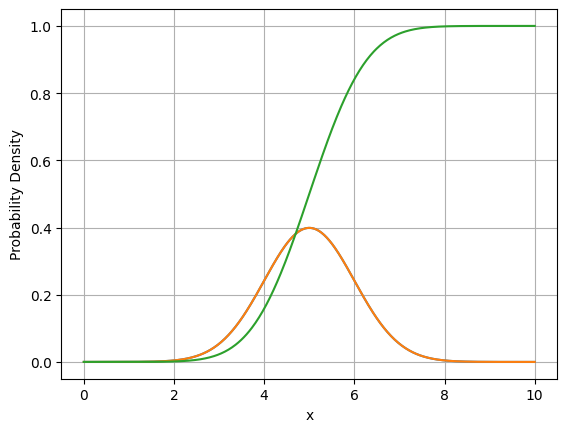

In [17]:
plt.plot(x, y, label="pdf1")
plt.plot(x_, y_, label="pdf2")
plt.plot(x_, cdf_values, label="cdf")
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.grid()

In [19]:
from ler.utils import create_inv_cdf_array

In [25]:
x_ = np.linspace(0, 10, 500)
y_ = gaussian(x_)
cdf_values = cumtrapz(y_, x_, initial=0)
y_norm = y_ / cdf_values[-1]
inv_cdf_ = create_inv_cdf_array(x_, y_)

In [31]:
inv_cdf, x = inv_cdf_[0], inv_cdf_[1]
@njit
def inverse_transform_sampler(size, inv_cdf, x):
    u = np.random.uniform(0, 1, size)
    idx = np.searchsorted(inv_cdf, u)
    x1, x0, y1, y0 = inv_cdf[idx], inv_cdf[idx-1], x[idx], x[idx-1]
    samples = y0 + (y1 - y0) * (u - x0) / (x1 - x0)
    return samples

# u = np.random.uniform(0, 1, 1000)
# idx = np.searchsorted(inv_cdf, u)
# x1, x0, y1, y0 = inv_cdf[idx], inv_cdf[idx-1], x[idx], x[idx-1]
# samples = y0 + (y1 - y0) * (u - x0) / (x1 - x0)


In [33]:
sample = inverse_transform_sampler(10000, inv_cdf, x)

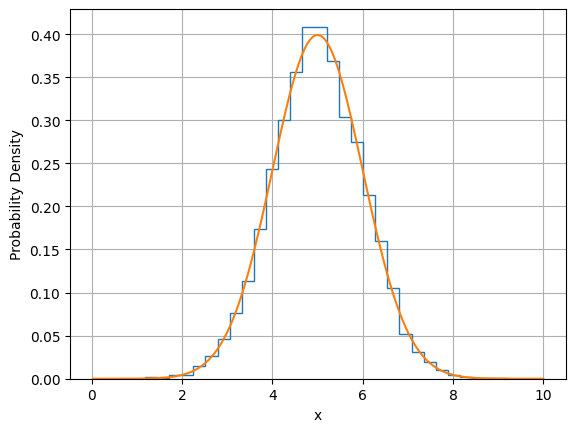

In [34]:
# plot histogram
plt.hist(sample, bins=30, density=True, histtype="step")
plt.plot(x, y_norm, label="pdf")
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.grid()
plt.show()

In [7]:
from gwcosmo import priors as p
model = p.BBH_powerlaw_gaussian(mminbh=4.98,
        mmaxbh=86.22,
        alpha=2.63,
        mu_g=33.07,
        sigma_g=5.69,
        lambda_peak=0.10,
        delta_m=4.82,
        beta=1.26,
)

/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/gwcosmo/prior/custom_math_priors.py:48: RuntimeWarning: overflow encountered in exp
  effe_prime[select_window] = _np.exp(_np.nan_to_num((delta_m/mprime[select_window])+(delta_m/(mprime[select_window]-delta_m))))
/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/gwcosmo/prior/custom_math_priors.py:162: RuntimeWarning: divide by zero encountered in log
  prob_ret =self.origin_prob.log_prob(x)+_np.log(window)
/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/gwcosmo/prior/custom_math_priors.py:160: RuntimeWarning: divide by zero encountered in log
  prob_ret =self.origin

In [8]:
model.sample(10)

(array([35.78978391,  9.29366366, 25.829409  ,  8.8829182 , 43.00895243,
         6.95742985,  7.43503832,  9.22707381, 14.9556415 , 15.81953693]),
 array([14.8332005 ,  8.37368836, 10.83199588,  8.68271548, 40.61268913,
         6.5423469 ,  6.85899397,  9.04366512, 12.91126767, 12.15067315]))

In [ ]:
 gw_parameters.keys() = ['mass_1', 'mass_2', 'mass_1_source', 'mass_2_source', 'zs', 'luminosity_distance', 'inclination', 'polarization_angle', 'phase', 'geocent_time', 'ra', 'dec', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl']

In [ ]:
    def sampler_uniform(
        self, size, min_=0, max_=np.pi, get_attribute=False, param=None
    ):

        if param:
            min_ = param["start_time"]
            max_ = param["end_time"]

        if get_attribute:
            return njit(lambda size_: np.random.uniform(min_, max_, size=size_))
        else:
            return np.random.uniform(min_, max_, size=size)

In [ ]:
 # for BBH
        if event_type == "BBH":
            a_min, a_max = -0.8, 0.8
            event_priors_ = dict(
                merger_rate_density="merger_rate_density_bbh_popI_II_oguri2018",
                source_frame_masses="binary_masses_BBH_popI_II_powerlaw_gaussian",
                zs=None,
                geocent_time="geocent_time_uniform",
                ra= njit(lambda size_: np.random.uniform(0, 2*np.pi, size=size_)),
                dec= njit(lambda size_: np.arcsin((np.random.uniform(0, 1, size=size_)-0.5)*np.pi)),
                phase= njit(lambda size_: np.random.uniform(0, 2*np.pi, size=size_)),
                psi= njit(lambda size_: np.random.uniform(0, np.pi, size=size_)),
                theta_jn= njit(lambda size_: np.arccos((np.random.uniform(0, 1, size=size_)-0.5)*2)),
            )
            event_prior_params_ = dict(
                merger_rate_density=dict(R0=23.9 * 1e-9, b2=1.6, b3=2.0, b4=30),
                source_frame_masses=dict(
                    mminbh=4.98,
                    mmaxbh=86.22,
                    alpha=2.63,
                    mu_g=33.07,
                    sigma_g=5.69,
                    lambda_peak=0.10,
                    delta_m=4.82,
                    beta=1.26,
                ),
                zs=None,
                geocent_time=dict(
                    start_time=1238166018, end_time=1238166018 + 31536000
                ),
                ra=None,
                dec=None,
                phase=None,
                psi=None,
                theta_jn=None,
            )
        # for BNS
        if event_type == "BNS":
            a_min, a_max = -0.05, 0.05
            event_priors_ = dict(
                merger_rate_density="merger_rate_density_bbh_popI_II_oguri2018",
                source_frame_masses="binary_masses_BNS_bimodal",
                spin="binary_spin_aligned",
                zs=None,
                geocent_time="geocent_time_uniform",
                ra= njit(lambda size_: np.random.uniform(0, 2*np.pi, size=size_)),
                dec= njit(lambda size_: np.arcsin((np.random.uniform(0, 1, size=size_)-0.5)*np.pi)),
                phase= njit(lambda size_: np.random.uniform(0, 2*np.pi, size=size_)),
                psi= njit(lambda size_: np.random.uniform(0, np.pi, size=size_)),
                theta_jn= njit(lambda size_: np.arccos((np.random.uniform(0, 1, size=size_)-0.5)*2)),
            )
            event_prior_params_ = dict(
                merger_rate_density=dict(R0=170.0 * 1e-9, b2=1.6, b3=2.0, b4=30),
                source_frame_masses=dict(
                    w=0.643,
                    muL=1.352,
                    sigmaL=0.08,
                    muR=1.88,
                    sigmaR=0.3,
                    mmin=1.0,
                    mmax=2.3,
                ),
                spin=dict(a_min=-0.05, a_max=0.05),
                zs=None,
                geocent_time=dict(
                    start_time=1238166018, end_time=1238166018 + 31536000
                ),
                ra=None,
                dec=None,
                phase=None,
                psi=None,
                theta_jn=None,
            )
        if event_type == "NSBH":
            pass

        # spin
        if not self.spin_zero:
            event_priors_["a1"] = "sampler_uniform"
            event_prior_params_["a1"] = dict(a_min=a_min, a_max=a_max)
            event_priors_["a2"] = "sampler_uniform"
            event_prior_params_["a2"] = dict(a_min=a_min, a_max=a_max)
        if self.spin_precession:
            event_priors_["tilt_1"] = njit(lambda size_: np.arccos((np.random.uniform(0, 1, size=size_)-0.5)*2))
            event_priors_["tilt_2"] = njit(lambda size_: np.arccos((np.random.uniform(0, 1, size=size_)-0.5)*2))
            event_priors_["phi_12"] = "sampler_uniform"
            event_prior_params_["phi_12"] = dict(min_=0, max_=2*np.pi)
            event_priors_["phi_jl"] = "sampler_uniform"
            event_prior_params_["phi_jl"] = dict(min_=0, max_=2*np.pi)

        # update the priors if input is given
        if event_priors:
            event_priors_.update(event_priors)
        if event_prior_params:
            event_prior_params_.update(event_prior_params)

        # dict of sampler names with description
        sampler_names_ = dict(
            sample_source_frame_masses="samples mass1 and mass2 of the compact binaries",
            sample_a1="samples spin magnitude of the compact binaries (body1)",
            sample_a2="samples spin magnitude of the compact binaries (body2)",
            sample_tilt_1="samples tilt angle of the compact binaries (body1)",
            sample_tilt_2="samples tilt angle of the compact binaries (body2)",
            sample_phi_12="samples azimuthal angle between the two spins",
            sample_phi_jl="samples azimuthal angle between the total angular momentum and the orbital angular momentum",
            sample_zs="samples source redshifts",
            sample_geocent_time="samples geocent_time",
            sample_ra="samples right ascension of sky position",
            sample_dec="samples declination of sky position",
            sample_phase="samples coalescence phase",
            sample_psi="samples polarization angle",
            sample_theta_jn="samples inclination",
        )

        return (event_priors_, event_prior_params_, sampler_names_)

In [20]:
def binary_masses_BBH_primordial_lognormal(m1, m2, m_min=1.0, m_max=100.0, Mc=20.0, sigma=0.3,
):
    """
    Function to sample source mass1 and mass2 with primordial origin. Refer to Eqn. 1 and 4 of Ng et al. 2022

    Parameters
    ----------
    size : `int`
        Number of samples to draw
    m_min : `float`
        Minimum mass of the black hole (primordial)
        default: 10.
    m_max : `float`
        Maximum mass of the black hole (primordial)
        default: 100.
    Mc, sigma : `float`
        Fitting parameters
        default: Mc=30.0, sigma=0.3

    Returns
    ----------
    pdf : `float`
    """

    # mass function for primordial
    psi = lambda m: np.exp(-np.log(m / Mc) ** 2 / (2 * sigma**2)) / (
        np.sqrt(2 * np.pi) * sigma * m
    )
    # probability density function
    pdf = (
        lambda m1, m2: (m1 + m2) ** (36 / 37)
        * (m1 * m2) ** (32 / 37)
        * psi(m1)
        * psi(m2)
    )

    return pdf(m1,m2)

In [21]:
binary_masses_BBH_primordial_lognormal(m1=10, m2=10)

0.08409131072891797